# HARDWARE

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

"""
To change attributes:
1) Change ATTRIBUTE and you're good to go
"""
ATTRIBUTE = 'polarity'
COUNTER = '_new'
PARALLEL = 1
PARALLEL_F = 1
PARALLEL_EXTRACTION = 1
TRAIN_SIZE = 5
DEV_SIZE = 5
TEST_SIZE = 5

import os
import sys

os.environ['SNORKELDBNAME'] = ATTRIBUTE + str(COUNTER) +'2'
os.environ['SNORKELDB'] = 'postgres://localhost:5432'# + os.environ['SNORKELDBNAME']
        
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/')
snorkel_postgres = os.environ['SNORKELDB'].startswith('postgres')
print snorkel_postgres

True


In [2]:
import os
if snorkel_postgres:
#     os.environ['SNORKELDBNAME'] = ATTRIBUTE + str(COUNTER) +'2'
    print os.system("dropdb " + os.environ['SNORKELDBNAME'])
    print os.system("createdb " + os.environ['SNORKELDBNAME'])
    print "SNORKELDB = %s" % os.environ['SNORKELDB']
    print "SNORKELDBNAME = %s" % os.environ['SNORKELDBNAME']
else:
    try:
        os.remove('snorkel.db')
    except:
        pass

from fonduer import SnorkelSession
session = SnorkelSession()

0
0
SNORKELDB = postgres://localhost:5432
SNORKELDBNAME = polarity_new2


## Parsing

In [3]:
# from fonduer.async_parser import HTMLParser, AsyncOmniParser
from fonduer.parser import HTMLPreprocessor, OmniParser
from fonduer.models import Document, Phrase
print "Starting async parse..."


# docs_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/train_digikey/html/'
# pdf_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/train_digikey/pdf/'
docs_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/dev/html/'
pdf_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/dev/pdf/'

doc_preprocessor = HTMLPreprocessor(docs_path, max_docs=10)

# corpus_parser = OmniParser(blacklist=['style'], flatten=['span','br'], tabular=True, lingual=True, visual=True, pdf_path=pdf_path)
corpus_parser = OmniParser(structural=True, lingual=True, visual=True, blacklist=['style'], flatten=['span','br'], pdf_path=pdf_path)
corpus_parser.apply(doc_preprocessor, parallelism=4)

# corpus_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
#                                  tabular=True, lingual=True,
#                                  visual=True)

# %time corpus_parser.apply(doc_preprocessor, docs_path, pdf_path, session, \
#                             max_docs=TRAIN_SIZE, parallel=PARALLEL)
# session.commit()
print "Documents:", session.query(Document).count()
print "Phrases:", session.query(Phrase).count()

Starting async parse...
Clearing existing...
Running UDF...
Documents: 10
Phrases: 1348


In [4]:
docs = session.query(Document).order_by(Document.name).all()

In [5]:
for i, d in enumerate(docs):
    print i, len(d.phrases), len(d.tables)

0 144 6
1 124 2
2 123 2
3 153 4
4 109 2
5 150 4
6 193 1
7 95 3
8 127 2
9 130 3


In [6]:
for i, d in enumerate(docs):
    print d.phrases[0].text, d.phrases[0].top, d.phrases[0].bottom

BC182 [54] [71]
Zetex - BC81840 Silicon planar medium power transistor datasheet [13, 65, 49, 13, 13, 13, 13, 13, 23] [22, 73, 64, 22, 22, 22, 22, 22, 32]
DISES00645-1 [209] [217]
BC856/857/858/859/860 PNP Epitaxial Silicon Transistor [71, 179, 124, 265, 265, 265, 265] [223, 188, 140, 279, 279, 279, 279]
BC546/7/8 [32] [49]
DTC114YE(SOT-523). [125, 172, 300, 183, 252] [143, 182, 314, 193, 261]
MCCCS09741-1 [113] [161]
2N3904 MMBT3904 PZT3904 - NPN General-Purpose Amplifier [61, 61, 61, 61, 61, 61, 61] [427, 427, 427, 427, 427, 427, 427]
DTC114ECA-1. [121, 276] [140, 286]
Microsoft Word - MMBT3904-E. [96, 61, 61, 96, 61] [119, 86, 86, 119, 86]


In [7]:
from fonduer.models import Document, Phrase


session.query(Phrase).count()

1348L

## Extraction

In [8]:
from fonduer.models import candidate_subclass

Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Define Matchers

In [9]:
from hardware_matchers import get_matcher

dict_path = os.environ['SNORKELHOME'] +\
    '/tutorials/fonduer/tables/data/hardware/gold_raw/digikey_part_dictionary.csv'
part_matcher = get_matcher('part', dict_path)
attr_matcher = get_matcher(ATTRIBUTE)

Using combined matcher.


### Define ContextSpaces

In [10]:
from hardware_spaces import get_space
    
part_ngrams = get_space('part')
attr_ngrams = get_space(ATTRIBUTE)

### Define Candidate Throttler

In [11]:
from hardware_throttlers import get_throttler

throttler = get_throttler(ATTRIBUTE)
# throttler = None
print throttler

<function polarity_throttler at 0x7fbf8ef8c668>


### Run CandidateExtractor

In [12]:
from fonduer.candidates import CandidateExtractor
# from snorkel.utils import get_ORM_instance
# from fonduer.async_candidates import parallel_extract

candidate_extractor = CandidateExtractor(Part_Attr, 
                        [part_ngrams, attr_ngrams], 
                        [part_matcher, attr_matcher], 
                        throttler=throttler)

%time candidate_extractor.apply(docs, split=0)

# corpus_names = ['Hardware Train', 'Hardware Dev']
# if TEST_SIZE:
#     corpus_names.append('Hardware Test')
# for corpus_name in corpus_names:
#     corpus = get_ORM_instance(Corpus, session, corpus_name)
#     print "Extracting Candidates from %s" % corpus
#     %time candidates = parallel_extract(session, candidate_extractor, corpus, \
#                                         corpus_name + ' Candidates', \
#                                         parallel=PARALLEL_EXTRACTION)
#     session.add(candidates)
#     print "%s contains %d Candidates" % (candidates, len(candidates))
# session.commit()

Clearing existing...
Running UDF...
[========================================] 100%
CPU times: user 1.46 s, sys: 12 ms, total: 1.47 s
Wall time: 1.78 s


In [13]:
train_cands = session.query(Part_Attr).filter(Part_Attr.split == 0).all()
print "Number of candidates:", len(train_cands)

Number of candidates: 407


In [14]:
print train_cands[0]
print train_cands[0][0].sentence.text
print train_cands[0][1].sentence.text

Part_Attr(Span("BC182", sentence=948, chars=[0,4], words=[0,0]), Span("NPN", sentence=951, chars=[0,2], words=[0,0]))
BC182, BC182B
NPN Silicon


### Second Pass

In [15]:
# from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
# from snorkel.utils import get_ORM_instance
# from snorkel.models import Corpus

# corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')

# # parts_by_doc = get_gold_parts_by_doc()
# parts_by_doc = get_manual_parts_by_doc(corpus.documents.all())
# # parts_by_doc = None

In [16]:
# import cPickle as pickle
# pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc_dev.pkl'

# with open(pickle_file, 'w') as f:
#     pickle.dump(parts_by_doc, f)

In [17]:
import cPickle as pickle
pickle_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/sandbox/parts_by_doc_dev.pkl'
with open(pickle_file, 'r') as f:
    parts_by_doc = pickle.load(f)

In [18]:
for i, d in enumerate(docs):
    print d.name

BC182-D
DIODS13249-1
DISES00645-1
FAIRS19194-1
KECCS05435-1
MCCCS08818-1
MCCCS09741-1
MMBT3904
RECTS01214-1
UTCLS01324-1


### Assess Recall

In [19]:
# from fonduer.models import Corpus, CandidateSet
from hardware_utils import entity_level_f1

# corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')
# candidates = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
candidates = train_cands

gold_file = os.environ['SNORKELHOME'] + \
    '/tutorials/fonduer/tables/data/hardware/dev/hardware_dev_gold.csv'
%time (ctp, cfp, cfn) = entity_level_f1(candidates, gold_file, ATTRIBUTE, docs, parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.753
Corpus Recall    0.973
Corpus F1        0.849
----------------------------------------
TP: 73 | FP: 24 | FN: 2

CPU times: user 384 ms, sys: 4 ms, total: 388 ms
Wall time: 413 ms


## Gold Labels

In [20]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ candidates snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

In [21]:
# import os
# from fonduer.models import CandidateSet
# from hardware_utils import load_hardware_labels

# data_sets = ['Dev']
# gold_file = {}
# gold_file['Dev'] = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/dev/hardware_dev_gold.csv'
# if TEST_SIZE:
#     data_sets.append('Test')
#     gold_file['Test'] = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/test/hardware_test_gold.csv'
# for data_set in data_sets:
#     candidate_set_name = 'Hardware %s Candidates' % data_set
#     candidates = session.query(CandidateSet).filter(
#         CandidateSet.name == candidate_set_name).one()
#     label_set_name = 'Hardware %s Candidates -- Gold' % data_set
#     annotation_key_name = 'Hardware %s Labels -- Gold' % data_set
#     %time gold_candidates, annotation_key = load_hardware_labels(session,\
#                            label_set_name, \
#                            annotation_key_name, \
#                            candidates, \
#                            gold_file[data_set], \
#                            ATTRIBUTE)
#     candidates_gold = session.query(CandidateSet).filter(
#         CandidateSet.name == candidate_set_name + ' -- Gold').one()
#     print "%d/%d Candidates in %s have positive Labels" % (
#         len(candidates_gold), len(candidates), candidates)

## Features

In [22]:
from fonduer.features.features import get_all_feats
for f in get_all_feats(candidates[0]):
    print f

('CORE_e1_SPAN_TYPE_[EXPLICIT]', 1)
('CORE_e1_STARTS_WITH_CAPITAL', 1)
('CORE_e1_LENGTH_1', 1)
('CORE_e2_SPAN_TYPE_[EXPLICIT]', 1)
('CORE_e2_STARTS_WITH_CAPITAL', 1)
('CORE_e2_LENGTH_1', 1)
(u'DDL_e1_WORD_SEQ_[BC182]', 1)
(u'DDL_e1_LEMMA_SEQ_[bc182]', 1)
(u'DDL_e1_POS_SEQ_[NN]', 1)
(u'DDL_e1_DEP_SEQ_[ROOT]', 1)
(u'DDL_e1_W_LEFT_1_[bc182b]', 1)
(u'DDL_e1_W_LEFT_POS_1_[NN]', 1)
(u'DDL_e1_W_LEFT_2_[, bc182b]', 1)
(u'DDL_e1_W_LEFT_POS_2_[, NN]', 1)
(u'DDL_e1_W_LEFT_3_[bc182 , bc182b]', 1)
(u'DDL_e1_W_LEFT_POS_3_[NN , NN]', 1)
(u'DDL_e1_W_RIGHT_1_[,]', 1)
(u'DDL_e1_W_RIGHT_POS_1_[,]', 1)
(u'DDL_e1_W_RIGHT_2_[, bc182b]', 1)
(u'DDL_e1_W_RIGHT_POS_2_[, NN]', 1)
(u'DDL_e1_W_LEMMA_L_1_R_1_[bc182b]_[,]', 1)
(u'DDL_e1_W_POS_L_1_R_1_[NN]_[,]', 1)
(u'DDL_e1_W_LEMMA_L_1_R_2_[bc182b]_[, bc182b]', 1)
(u'DDL_e1_W_POS_L_1_R_2_[NN]_[, NN]', 1)
(u'DDL_e1_W_LEMMA_L_2_R_1_[, bc182b]_[,]', 1)
(u'DDL_e1_W_POS_L_2_R_1_[, NN]_[,]', 1)
(u'DDL_e1_W_LEMMA_L_2_R_2_[, bc182b]_[, bc182b]', 1)
(u'DDL_e1_W_POS_L_2_R_2_[

### Extract Features

In [23]:
session.query(Part_Attr).filter(Part_Attr.split == 0).count()
print isinstance(Part_Attr, type)
print Part_Attr.__name__

True
Part_Attr


#### Extract with optimized postgres batch extractor

In [49]:
from fonduer.async_annotations import BatchFeatureAnnotator

featurizer = BatchFeatureAnnotator(Part_Attr)
%time F_train = featurizer.apply(split=0, parallelism=4)
F_train

Clearing existing...
Running UDF...
Copying part_attr_feature to postgres
COPY 407

CPU times: user 244 ms, sys: 100 ms, total: 344 ms
Wall time: 6.18 s


<407x2325 sparse matrix of type '<type 'numpy.float32'>'
	with 39278 stored elements in Compressed Sparse Row format>

#### Extract with default Snorkel extractor

In [50]:
#from fonduer.async_annotations import 
from fonduer.annotations import FeatureAnnotator
from fonduer.features.features import get_all_feats

featurizer = FeatureAnnotator(f=get_all_feats)
%time F_train = featurizer.apply(split=0, parallelism=4)
F_train
#print docs[0]
#print session.query(Part_Attr).filter(Part_Attr.split == 0).filter(Part_Attr.part.sentence.document_id==531).all()

Clearing existing...
Running UDF...
CPU times: user 8.11 s, sys: 632 ms, total: 8.74 s
Wall time: 18.1 s


<407x2325 sparse matrix of type '<type 'numpy.float64'>'
	with 39278 stored elements in Compressed Sparse Row format>

from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Train Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
test  = get_ORM_instance(CandidateSet, session, 'Hardware Test Candidates')

if snorkel_postgres:
    from fonduer.async_annotations import annotate
    print "Starting async featurization..."
    %time F_train = annotate(train, parallel=PARALLEL_F, dynamic_scheduling=False)
    %time F_dev   = annotate(dev, parallel=PARALLEL_F, dynamic_scheduling=False,\
                             keyset = 'Hardware Train Candidates')
    if TEST_SIZE:
        %time F_test = annotate(test, parallel=PARALLEL_F, dynamic_scheduling=False,\
                                keyset = 'Hardware Train Candidates')
    
else:
    from fonduer.models import CandidateSet
    from fonduer.fast_annotations import FeatureManager
    from snorkel.utils import get_ORM_instance

    print "Starting sync featurization..."
    feature_manager = FeatureManager()
    %time F_train = feature_manager.create(session, train, 'Train Features')
    %time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

## LFs

In [ ]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ featurized snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Train Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Dev Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

### Define LFs

In [51]:
from hardware_lfs import get_lfs

LFs = get_lfs(ATTRIBUTE)

In [52]:
for lf in LFs:
    print lf(candidates[0])

0
0
0
0
1
0
0
1
0
1
1
0


### Apply LFs

In [54]:
from fonduer.async_annotations import BatchLabelAnnotator
labeler = BatchLabelAnnotator(Part_Attr, lfs = LFs)
%time L_train=labeler.apply(split=0, parallelism=4)
L_train

Clearing existing...
Running UDF...
Copying part_attr_label to postgres
COPY 407

CPU times: user 56 ms, sys: 40 ms, total: 96 ms
Wall time: 4.13 s


<407x12 sparse matrix of type '<type 'numpy.float32'>'
	with 997 stored elements in Compressed Sparse Row format>

### Assess LF accuracy

In [56]:
%time L_train.lf_stats_legacy()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.78 ms


,conflicts,coverage,j,overlaps
LF_part_complement,0.000000,0.000000,0,0.000000
LF_polarity_complement,0.046683,1.000000,1,0.857494
LF_polarity_transistor_type,0.000000,0.506142,2,0.506143
LF_many_p_siblings,0.000000,0.000000,3,0.000000
LF_polarity_in_header_tag,0.000000,0.584767,4,0.584767
LF_polarity_right_of_part,0.000000,0.095823,5,0.095823
LF_replacement_table,0.000000,0.000000,6,0.000000
LF_both_present,0.000000,0.000000,7,0.000000
LF_please_to_left,0.000000,0.000000,8,0.000000
LF_polarity_part_tabular_align,0.000000,0.000000,9,0.000000


## Learn and Evaluate

In [ ]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ features snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Development Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

# label_manager = LabelManager()
# %time L_train = label_manager.load(session, train, 'LF Labels')

In [57]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

/home/xiao/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


CPU times: user 4.27 s, sys: 16 ms, total: 4.29 s
Wall time: 4.31 s


In [58]:
train_marginals = gen_model.marginals(L_train)

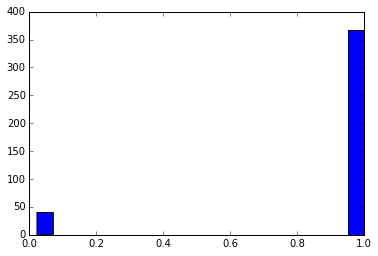

In [59]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [60]:
gen_model.weights.lf_accuracy()

array([ 0.52003846,  0.86584998,  0.70185029,  0.5174859 ,  0.73143049,
        0.55349053,  0.51577215,  0.52113194,  0.52252852,  0.52219823,
        0.54932103,  0.5512824 ])

In [61]:
# from snorkel.learning import NaiveBayes

# gen_model = NaiveBayes()
# %time gen_model.train(L_train, n_iter=2000, rate=1e-3, mu=1e-6)
# train_marginals = gen_model.marginals(L_train)

In [64]:
from pprint import pprint
pprint(zip([lf.__name__ for lf in LFs], gen_model.weights.lf_accuracy_log_odds))
print min(train_marginals)
print max(train_marginals)

[('LF_replacement_table', 0.080196811906242171),
 ('LF_many_p_siblings', 1.8647529478426847),
 ('LF_part_complement', 0.85612435777634732),
 ('LF_please_to_left', 0.069972126521801833),
 ('LF_polarity_transistor_type', 1.0018924200883601),
 ('LF_polarity_part_tabular_align', 0.21478404238605395),
 ('LF_polarity_part_horz_align', 0.063109534574668988),
 ('LF_polarity_part_vert_align', 0.084578124571248442),
 ('LF_polarity_right_of_part', 0.090175155405097504),
 ('LF_polarity_in_header_tag', 0.088851316939357453),
 ('LF_polarity_complement', 0.1979277737978711),
 ('LF_both_present', 0.20585345373413974)]
0.0234419762689
0.999748248037


In [65]:
from snorkel.learning import SparseLogisticRegression

disc_model = SparseLogisticRegression()
%time disc_model.train(F_train, train_marginals, n_epochs=200, lr=0.001)

[SparseLR] lr=0.001 l1=0.0 l2=0.0
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=407  #epochs=200  batch size=100
[SparseLR] Epoch 0 (0.43s)	Avg. loss=0.639306	NNZ=2325
[SparseLR] Epoch 5 (0.57s)	Avg. loss=0.219277	NNZ=2325
[SparseLR] Epoch 10 (0.71s)	Avg. loss=0.126980	NNZ=2325
[SparseLR] Epoch 15 (0.85s)	Avg. loss=0.091789	NNZ=2325
[SparseLR] Epoch 20 (1.10s)	Avg. loss=0.073863	NNZ=2325
[SparseLR] Epoch 25 (1.25s)	Avg. loss=0.063313	NNZ=2325
[SparseLR] Epoch 30 (1.39s)	Avg. loss=0.056584	NNZ=2325
[SparseLR] Epoch 35 (1.54s)	Avg. loss=0.052048	NNZ=2325
[SparseLR] Epoch 40 (1.68s)	Avg. loss=0.048861	NNZ=2325
[SparseLR] Epoch 45 (1.83s)	Avg. loss=0.046546	NNZ=2325
[SparseLR] Epoch 50 (1.99s)	Avg. loss=0.044818	NNZ=2325
[SparseLR] Epoch 55 (2.13s)	Avg. loss=0.043498	NNZ=2325
[SparseLR] Epoch 60 (2.28s)	Avg. loss=0.042469	NNZ=2325
[SparseLR] Epoch 65 (2.42s)	Avg. loss=0.041651	NNZ=2325
[SparseLR] Epoch 70 (2.58s)	Avg. loss=0.040992	NNZ=2325
[SparseLR] Epoch 75 (2

In [66]:
# from snorkel.learning import LogReg

# disc_model = LogReg()
# %time disc_model.train(F_train, train_marginals, n_iter=10000, rate=1e-3)

In [ ]:
from fonduer.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Dev Labels -- Gold')
L_dev.shape

In [ ]:
tp, fp, tn, fn = disc_model.score(session, F_dev, L_dev)

In [ ]:
from fonduer.models import Corpus
from hardware_utils import entity_level_f1
import os

gold_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/dev/hardware_dev_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Dev').one()
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc=None)
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc=parts_by_doc)

### Error Analysis

### Oracle

In [ ]:
from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
from snorkel.utils import get_ORM_instance
from fonduer.models import Corpus

parts_by_doc = get_gold_parts_by_doc()
(TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc)

### Test Results

In [ ]:
if TEST_SIZE:
    from fonduer.annotations import LabelManager
    label_manager = LabelManager()
    L_test = label_manager.load(session, test, 'Hardware Test Labels -- Gold')
    L_test.shape
    
    tp, fp, tn, fn = disc_model.score(session, F_test, L_test, b=0.91)
    
    from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
    from snorkel.utils import get_ORM_instance
    from fonduer.models import Corpus

    corpus = get_ORM_instance(Corpus, session, 'Hardware Test')

    # parts_by_doc_test = get_manual_parts_by_doc(corpus.documents.all())
    # parts_by_doc_test = None
    import cPickle as pickle
    pickle_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/sandbox/parts_by_doc_test.pkl'
    with open(pickle_file, 'r') as f:
        parts_by_doc_test = pickle.load(f)

    from hardware_utils import entity_level_f1

    gold_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/test/hardware_test_gold.csv'
    (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus)
    (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc_test)